# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science 
## Homework 3 - Bayesian Analysis



**Harvard University**<br/>
**Spring 2020**<br/>
**Instructors**: Mark Glickman, Pavlos Protopapas, & Chris Tanner 


<hr style="height:2pt">

### Homework 3 is due March 5th

In [9]:
#PLEASE RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment, please follow the instructions on Canvas.
- Please restart the kernel and run the entire notebook again before you submit.

<hr style="height:2pt">

### Please use the libraries below:

In [10]:
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
%matplotlib inline 
from datetime import datetime as dt
from scipy.special import expit


<hr style="height:2pt">

### Contraceptive Usage by Bangladeshi Women

In the second part of this assignment, you are provided with data sets `dataset_2_train.csv` and `dataset_2_test.csv`containing details of contraceptive usage by 1934 Bangladeshi women. There are four attributes for each woman, along with a label indicating if she uses contraceptives. The attributes include
* district: identifying code for the district the woman lives in
* urban: type of region of residence
* living.children: number of living children
* age-mean: age of the woman (in years, centered around mean)

The women are grouped into 60 districts. The task is to build a classification model that can predict if a given woman uses contraceptives.


### Part A: Bayesian Logistic Regression

The first model we will fit to the contraceptives data is a varying-intercept logistic regression model, where the intercept varies by district.

Prior distribution:

$\beta_{0j} \sim N(\mu_0,\sigma_0^2),$ with $\mu_0 \sim N(0,10000)$ and $\frac{1}{\sigma^2_0} \sim \text{Gamma}(0.1,0.1)$.

$\beta_1 \sim N(0,10000)$, $\beta_2\sim N(0,10000)$, $\beta_3 \sim N(0,10000)$

Model for data:

$Y_{ij} \sim \text{Bernoulli}(p_{ij})$

$\text{logit}\:p_{ij} = \beta_{0j} + \beta_1 \times \text{urban} + \beta_2 \times \text{living.children} + \beta_3 \times \text{age-mean}$,

where $Y_{ij}$ is 1 if woman $i$ in district $j$ uses contraceptives, and 0 otherwise, and where $i \in \{1,...,N\}$ and $j \in \{1,...,J\}$. $N$ is the number of observations in the data, and $J$ is the number of districts. The above notation assumes $N(\mu, \sigma^2)$ is a Normal distribution with mean $\mu$ and variance $\sigma^2$.

##### **A1**

As a preprocessing step, map the district number 61 to the number 54 so that the districts are in order. Also, re-name district 60 to be district 0 so that the districts are numbered 0 through 59. **We use this numbering throughout the homework, and will grade using these district numbers**

In [119]:
#your code here
data_train = pd.read_csv('data/dataset_2_train.csv')
data_test = pd.read_csv('data/dataset_2_test.csv')
# map 61 to 54
data_train.loc[data_train['district'] == 61, 'district'] = 54
data_test.loc[data_test['district'] == 61, 'district'] = 54
# rename 60 to 0
data_train.loc[data_train['district'] == 60, 'district'] = 0
data_test.loc[data_test['district'] == 60, 'district'] = 0

data_train.head()

,district,urban,living.children,age_mean,contraceptive_use
0,35,0,4,2.4400,0
1,22,0,2,-1.5599,1
2,29,0,2,-8.5599,1
3,5,0,3,-4.5599,1
4,34,1,4,8.4400,0


##### **A2**

First, we'll verify that pymc3 can recover the hidden parameter values. To do so, we'll hard-code known values and simulate data from the model, then using that data we'll check if pymc3 can get back the parameters we hard-coded. If it does, we'll have hope that it can get the hidden parameter values that generated the real data.

Use the following hard-coded values:  
$\mu_0 = 2$

$\sigma^2_0 = 1$

$\beta_{0j} \sim N(\mu_0,\sigma_0^2)$ for all sixty districts

$\beta_1 = 4$

$\beta_2 = -3$

$\beta_3 = -2$

**Verify that these parameters give an overall average of 46 to 48 percent of subjects using contraceptives**

In [23]:
#your code here
# True parameter values
mu_0 = 2
sigma_0 = 1

beta_1 = 4
beta_2 = -3
beta_3 = -2
# Simulate outcome variable
# get 60 slopes for different district
num_district = len(data_train['district'].unique())
beta_0 = np.random.normal(mu_0, sigma_0, num_district)
# P = inverse_logit(output from logistic regression)
temp = beta_0[data_train['district']] + beta_1*data_train['urban'] + beta_2 * data_train['living.children'] + beta_3 * data_train['age_mean']
P = expit(temp)
# convert probability to binary variable
Y = np.random.binomial(1, P) # get 1 for each probability p
# report 
print('These parameters give an overall average of {:.2f} percent of subjects using contraceptives'.format(Y.mean()* 100))

These parameters give an overall average of 47.47 percent of subjects using contraceptives


##### **A3**

Fit the varying-intercept model specified above to your simulated data. Reasonably good convergence may require adjustments to the number of tuning samples and the target acceptance rate as suggested in pymc3's warnings.

Note: It is wise to take advantage of a model's built-in `summary` method to inspect it after fitting

In [84]:
from scipy import optimize
#your code here
logit_model = pm.Model()

with logit_model:
    # varying coefficient beta_0 for each intercept
    mu_0 = pm.Normal(name = 'mu_0', mu = 0, sigma = 100)
    # sig2_inv_0 = tau_0 for normal model
    tau_0 = pm.Gamma(name = 'tau_0', alpha = 0.1, beta = 0.1)
    beta_0 = pm.Normal(name = 'beta_0', mu = mu_0, tau = tau_0, shape = num_district)
    # varying intercepts
    intercepts = beta_0[data_train.district.values]
    # three beta coefs
    beta_1 = pm.Normal(name = 'beta_1', mu = 0, sigma = 100)
    beta_2 = pm.Normal(name = 'beta_2', mu = 0, sigma = 100)
    beta_3 = pm.Normal(name = 'beta_3', mu = 0, sigma = 100)
    # Expected value of outcome - posterior
    # get logit p
    mu_logit_p = pm.Deterministic('mu_p', intercepts + beta_1*data_train['urban'] 
                                  + beta_2 * data_train['living.children'] 
                                  + beta_3 * data_train['age_mean'])
    # data likelihood
    obs = pm.Bernoulli('observed', logit_p = mu_logit_p, observed = Y)
    # trace
    trace = pm.sample(4000, tune=2000, target_accept=0.8)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_3, beta_2, beta_1, beta_0, tau_0, mu_0]
Sampling 2 chains, 1,277 divergences: 100%|██████████| 12000/12000 [01:32<00:00, 129.29draws/s]
There were 1168 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.1801412810977631, but should be close to 0.8. Try to increase the number of tuning steps.
There were 109 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


##### **A4**

Plot the trace plots of the MCMC sampler for the parameters $\mu_0, \sigma_0, \beta_1, \beta_2, \beta_3$. Based on these and the R-hat values, does it look like the samplers converged?

/Users/Ruby/anaconda3/envs/cs109b/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/Ruby/anaconda3/envs/cs109b/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/Ruby/anaconda3/envs/cs109b/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/Ruby/anaconda3/envs/cs109b/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not ef

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11284f490>,
      dtype=object)

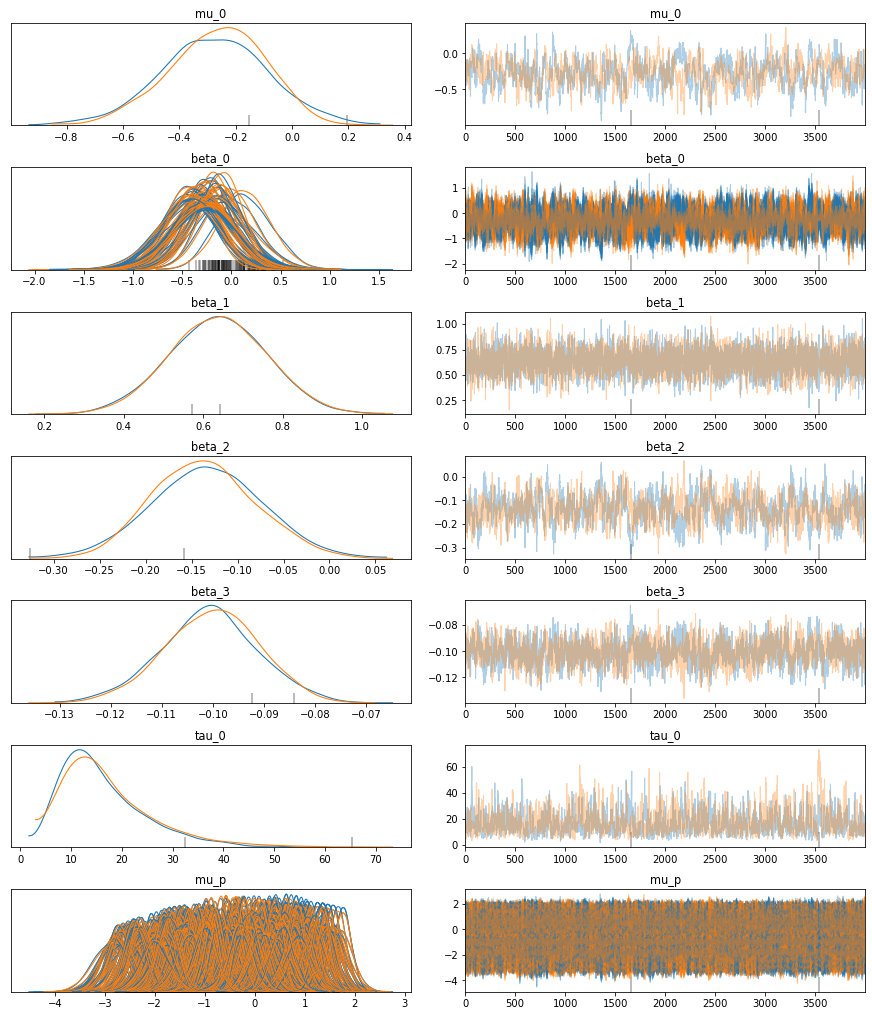

In [62]:
#your code here
pm.traceplot(trace)

In [55]:
pm.summary(trace, var_names=['mu_0', 'tau_0', 'beta_0', 'beta_1', 'beta_2'])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu_0,3.284,1.502,0.724,6.028,0.162,0.115,86.0,86.0,87.0,135.0,1.04
beta_0[0],4.264,2.089,0.774,8.047,0.202,0.143,107.0,107.0,93.0,217.0,1.03
beta_0[1],3.271,1.994,-0.067,7.221,0.169,0.120,139.0,139.0,132.0,262.0,1.03
beta_0[2],3.279,1.983,0.027,7.454,0.168,0.119,139.0,139.0,135.0,253.0,1.02
beta_0[3],3.255,2.006,0.102,7.364,0.164,0.116,149.0,149.0,139.0,327.0,1.02
...,...,...,...,...,...,...,...,...,...,...,...
mu_p[962],13.956,3.388,8.605,20.095,0.322,0.228,111.0,111.0,91.0,204.0,1.02
mu_p[963],7.083,2.036,3.599,10.884,0.149,0.105,187.0,187.0,184.0,637.0,1.02
mu_p[964],9.820,2.488,5.913,14.708,0.199,0.141,156.0,156.0,144.0,1030.0,1.01
mu_p[965],-16.903,4.047,-24.530,-10.684,0.393,0.279,106.0,106.0,84.0,119.0,1.02


your response here

##### **A5**

Plot histograms of the posterior distributions for the parameters $\beta_{0,9}$, $\beta_{0,19}$, $\beta_{0,29}$, ..., $\beta_{0,59}$. Are the actual parameters that you generated contained within these posterior distributions? 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x153bb70d0>,
      dtype=object)

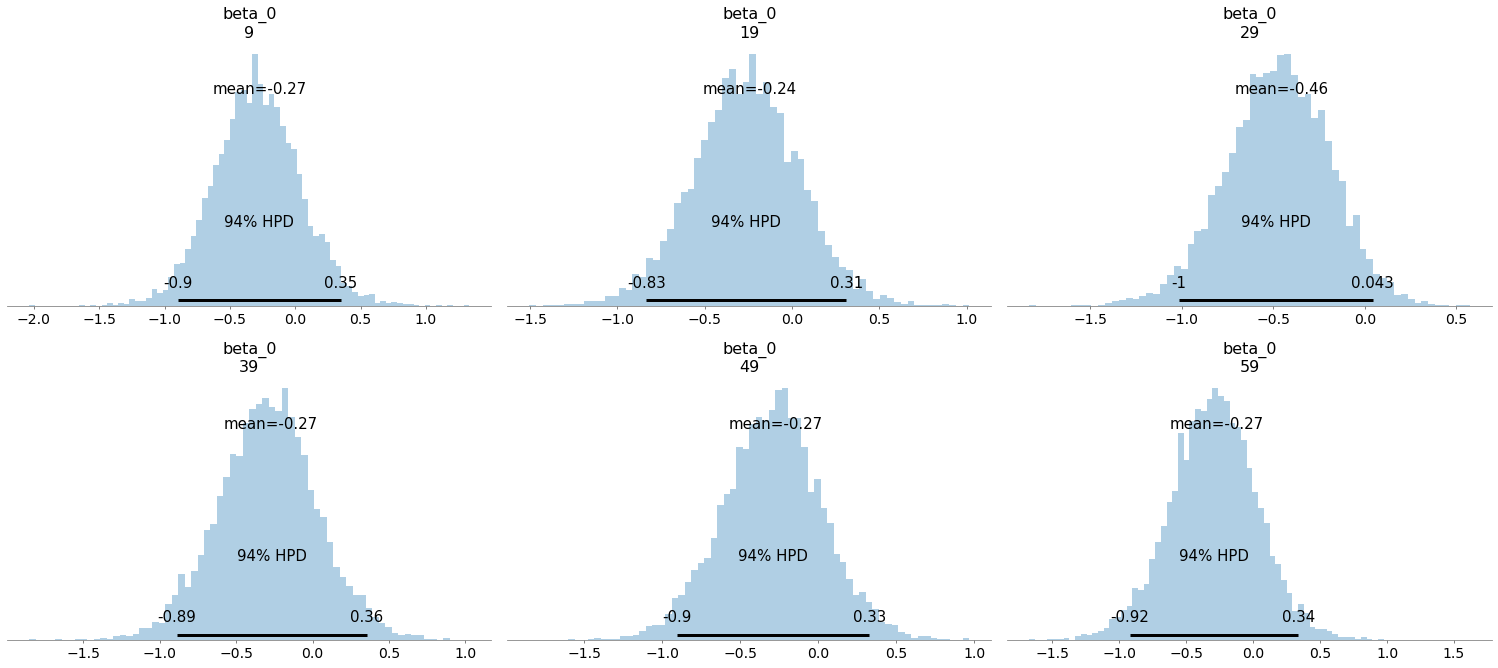

In [63]:
#your code here
pm.plot_posterior(trace, var_names=['beta_0'], coords = {'beta_0_dim_0': np.arange(9, 69, 10)}, 
                  kind = 'hist')

your response here


##### **A6**

We now fit our model to the actual data. Fit the varying-intercept model to the real training data.

In [85]:
#your code here
with logit_model:
    # data likelihood
    real_obs = pm.Bernoulli('real_obs', logit_p = mu_logit_p, observed = data_train['contraceptive_use'])
    # trace
    trace2 = pm.sample(4000, tune=2000, target_accept=0.8)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_3, beta_2, beta_1, beta_0, tau_0, mu_0]
Sampling 2 chains, 108 divergences: 100%|██████████| 12000/12000 [00:56<00:00, 210.75draws/s]
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 101 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6786986633459479, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


##### **A7**

Check the convergence by examining the trace plots and R-hats, as you did with the simulated data. What do you observe?

/Users/Ruby/anaconda3/envs/cs109b/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/Ruby/anaconda3/envs/cs109b/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/Ruby/anaconda3/envs/cs109b/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/Ruby/anaconda3/envs/cs109b/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not ef

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1285f6310>,
      dtype=object)

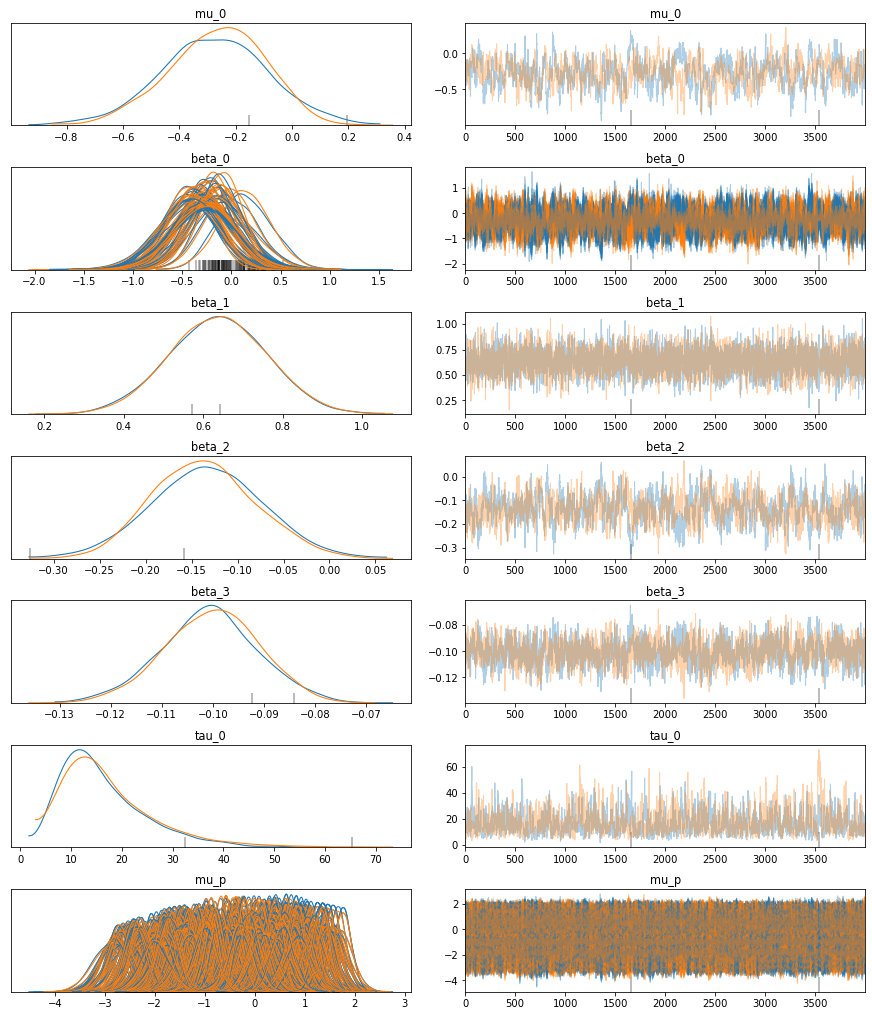

In [58]:
#your code here
pm.traceplot(trace2)

In [60]:
pm.summary(trace, var_names=['mu_0', 'tau_0', 'beta_0', 'beta_1', 'beta_2'])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu_0,-0.273,0.180,-0.621,0.051,0.010,0.007,328.0,328.0,327.0,538.0,1.0
tau_0,16.774,8.982,4.014,33.113,0.326,0.253,759.0,629.0,845.0,1214.0,1.0
beta_0[0],-0.018,0.266,-0.498,0.506,0.009,0.006,876.0,876.0,873.0,1789.0,1.0
beta_0[1],-0.316,0.307,-0.898,0.261,0.011,0.008,820.0,820.0,812.0,2382.0,1.0
beta_0[2],-0.273,0.333,-0.890,0.358,0.010,0.007,1010.0,1010.0,1003.0,2693.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
beta_0[57],-0.273,0.330,-0.925,0.327,0.010,0.007,990.0,990.0,986.0,2558.0,1.0
beta_0[58],-0.412,0.278,-0.958,0.083,0.010,0.007,706.0,706.0,705.0,1459.0,1.0
beta_0[59],-0.274,0.333,-0.921,0.335,0.010,0.007,1035.0,1035.0,1015.0,2629.0,1.0
beta_1,0.636,0.120,0.407,0.860,0.002,0.001,3588.0,3588.0,3587.0,4985.0,1.0


The traceplot of parameter values indicate convergence because of constantly jumping pattern. All R-hat values are close to 1, so the samples are good enough.

##### **A8**

Based on the posterior means, which district has the highest base rate of contraceptive usage (independent of other factors like urban population)? Which district has the lowest?

In [73]:
#your code here
df = pm.summary(trace, var_names=['beta_0'])
max_label = df[['mean']].idxmax(axis = 0)
min_label = df[['mean']].idxmin(axis = 0)
print('Based on the posterior means')
print('{} district has the highest base rate of contraceptive usage'.format(max_label[0][7]))
print('{} district has the lowest base rate of contraceptive usage'.format(min_label[0][7]))

Based on the posterior means
6 district has the highest base rate of contraceptive usage
5 district has the lowest base rate of contraceptive usage


your response here

6 district has the highest base rate of contraceptive usage

5 district has the lowest base rate of contraceptive usage

##### **A9**

What are the posterior means of $\mu_0$ and $\sigma^2_0$? Do these values offer any evidence in support of or against the varying-intercept model, compared to a model with a single intercept value for all districts or a model with an intercept of 0 for all districts?

In [79]:
#your code here
df = pm.summary(trace, var_names=['mu_0', 'tau_0'])
display(df[['mean']])
# tau_0 = sigma_inv_2
print('sigma = {:.4f}'.format((1 / df.loc['tau_0', 'mean'])**0.5))

,mean
mu_0,-0.273
tau_0,16.774


sigma = 0.2442


your response here

Since we have different intercepts for different district, and these coefficients come from a normal distribution with standard deviation 0.24. The standard deviation is large compared with the mean -0.273, so they support the varying-intercept model.

### Part B: Varying-Coefficients Model

The next model we will fit to the contraceptives data is a varying-coefficients logistic regression model, where the coefficients on living.children, age-mean, and urban vary by district.

$\beta_{0j} \sim N(\mu_0,\sigma_0^2),$ with $\mu_0 \sim N(0,10000)$ and $\frac{1}{\sigma_0^2} \sim \text{Gamma}(0.1,0.1)$.

$\beta_{1j} \sim N(0,\sigma_1^2)$, with $\frac{1}{\sigma^2_1} \sim \text{Gamma}(0.1,0.1)$

$\beta_{2j}\sim N(0,\sigma_2^2)$, with $\frac{1}{\sigma^2_2}\sim \text{Gamma}(0.1,0.1)$

$\beta_{3j} \sim N(0,\sigma_3^2)$, with $\frac{1}{\sigma^2_3} \sim \text{Gamma}(0.1,0.1)$

Model for data:

$Y_{ij} \sim \text{Bernoulli}(p_{ij})$

$\text{logit}\:p_{ij} = \beta_{0j} + \beta_{1j} \times \text{urban} + \beta_{2j} \times \text{living.children} + \beta_{3j} \times \text{age-mean}$,

##### **B1**

Fit the model to the real data. Plot posterior means for each of the coefficients to the predictors. What do you conclude from these graphs?

In [137]:
#your code here
var_coef = pm.Model()

with var_coef:
    # varying coefficient beta_0 for each intercept
    mu_0 = pm.Normal(name = 'mu_0', mu = 0, sigma = 100)
    # sig2_inv_0 = tau_0 for normal model
    tau_0 = pm.Gamma(name = 'tau_0', alpha = 0.1, beta = 0.1)
    beta_0 = pm.Normal(name = 'beta_0', mu = mu_0, tau = tau_0, shape = num_district)
    # varying intercepts
    intercepts = beta_0[data_train.district.values]
    # three beta coefs
    tau_1 = pm.Gamma(name = 'tau_1', alpha = 0.1, beta = 0.1)
    beta_1 = pm.Normal(name = 'beta_1', mu = 0, tau = tau_1, shape = num_district)
    slope_1 = beta_1[data_train.district.values]
    
    tau_2 = pm.Gamma(name = 'tau_2', alpha = 0.1, beta = 0.1)
    beta_2 = pm.Normal(name = 'beta_2', mu = 0, tau = tau_2, shape = num_district)
    slope_2 = beta_2[data_train.district.values]
    
    tau_3 = pm.Gamma(name = 'tau_3', alpha = 0.1, beta = 0.1)
    beta_3 = pm.Normal(name = 'beta_3', mu = 0, tau = tau_3, shape = num_district)
    slope_3 = beta_3[data_train.district.values]
    # Expected value of outcome - posterior
    # get logit p
    mu_logit_p = pm.Deterministic('mu_p', intercepts + slope_1*data_train['urban'] 
                                  + slope_2 * data_train['living.children'] 
                                  + slope_3 * data_train['age_mean'])
    # data likelihood
    obs = pm.Bernoulli('observed', logit_p = mu_logit_p, observed = data_train['contraceptive_use'])
    # trace
    trace = pm.sample(4000, tune=2000, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_3, tau_3, beta_2, tau_2, beta_1, tau_1, beta_0, tau_0, mu_0]
Sampling 2 chains, 0 divergences: 100%|██████████| 12000/12000 [01:44<00:00, 114.36draws/s]
The number of effective samples is smaller than 10% for some parameters.


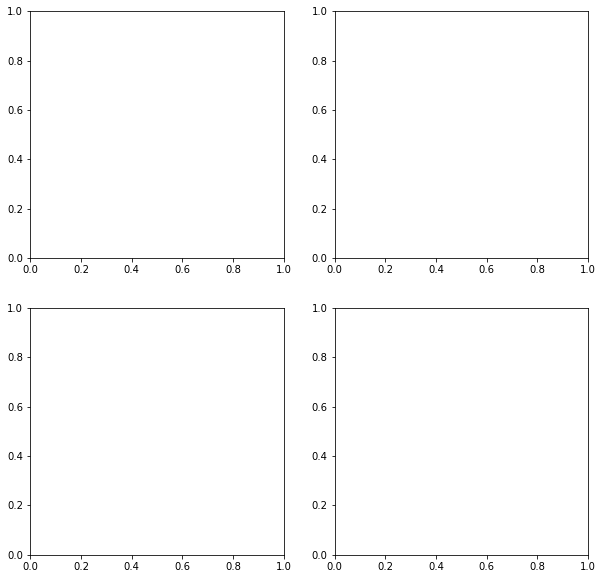

In [143]:
# plot
fig, axes = plt.subplots(2,2, figsize = (10,10))
# beta 0
axes[0,0] = plt.

In [138]:
df = pm.summary(trace, var_names=['beta_0', 'beta_1', 'beta_2', 'beta_3'])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta_0[0],-1.046,0.444,-1.902,-0.262,0.007,0.006,3821.0,3114.0,4160.0,4099.0,1.0
beta_0[1],-0.953,0.410,-1.705,-0.150,0.006,0.005,4735.0,3587.0,4907.0,4364.0,1.0
beta_0[2],-0.867,0.445,-1.745,-0.037,0.005,0.004,7976.0,5667.0,8118.0,5245.0,1.0
beta_0[3],-0.683,0.509,-1.671,0.298,0.006,0.005,6653.0,5247.0,6760.0,4018.0,1.0
beta_0[4],-0.667,0.440,-1.491,0.183,0.006,0.004,5993.0,5993.0,6039.0,4523.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
beta_3[55],-0.048,0.091,-0.224,0.115,0.001,0.001,13732.0,4443.0,13838.0,5872.0,1.0
beta_3[56],-0.019,0.047,-0.108,0.066,0.000,0.000,10385.0,5015.0,10405.0,6546.0,1.0
beta_3[57],0.041,0.063,-0.077,0.158,0.001,0.001,11799.0,5848.0,11807.0,6657.0,1.0
beta_3[58],0.031,0.046,-0.055,0.118,0.000,0.000,11672.0,5337.0,11721.0,6361.0,1.0


your response here

##### **B2**

Use all of the information you've gleaned thus far to build a final Bayesian logistic regression classifier on the train set. Then, use your model to make predictions on the test set. Report your model's classification percentage.

In [11]:
#your code here


your response here